In [596]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple, deque
import random
import seaborn as sns

In [597]:
class Environment:

    def __init__(self, world_map):
        self.world_h = len(world_map)
        self.world_w = len(world_map[0])
        self.cargos = dict()
        self.desired_space = []
        # change r in a world map to -1
        modified_world = []
        for row in world_map:
            modified_row = []
            for c in row:
                if c == 'r':
                    modified_row.append(-1)
                else:
                    modified_row.append(int(c))
            modified_world.append(modified_row)
        self.world = modified_world
        self.world = np.array(self.world)

        for i in range(len(world_map)):
            for j in range(len(world_map[0])):
                if world_map[i][j] == 'r':
                    self.desired_space.append((i, j))
                if world_map[i][j].isdigit() and int(world_map[i][j]) != 0:
                    if world_map[i][j] not in self.cargos:
                        self.cargos[world_map[i][j]] = []
                    self.cargos[world_map[i][j]].append((i, j))
        for key in self.cargos:
            self.cargos[key] = np.array(self.cargos[key])

        self.desired_space = np.array(self.desired_space)

        self.init_cargos = self.cargos.copy()
        self.init_desired_space = self.desired_space.copy()
        self.init_world = self.world.copy()

    def move_cargo(self, cargo, action):
        if action == 'D':
            new_pos = self.cargos[cargo] + np.array([1, 0])
        elif action == 'U':
            new_pos = self.cargos[cargo] + np.array([-1, 0])
        elif action == 'R':
            new_pos = self.cargos[cargo] + np.array([0, 1])
        elif action == 'L':
            new_pos = self.cargos[cargo] + np.array([0, -1])
        else:
            raise ValueError('Action must be one of D, U, R, L')

        if np.any(new_pos < 0) or np.any(new_pos >= np.array([self.world_h, self.world_w])):
            raise ValueError('New position is out of bounds')
        self.world[self.cargos[cargo][:, 0], self.cargos[cargo][:, 1]] = 0
        for i, j in self.desired_space:
            self.world[i, j] = -1
        self.world[new_pos[:, 0], new_pos[:, 1]] = int(cargo)
        self.cargos[cargo] = new_pos

    def check_move(self, cargo, action):
        if action == 'D':
            new_pos = self.cargos[cargo] + np.array([1, 0])
        elif action == 'U':
            new_pos = self.cargos[cargo] + np.array([-1, 0])
        elif action == 'R':
            new_pos = self.cargos[cargo] + np.array([0, 1])
        elif action == 'L':
            new_pos = self.cargos[cargo] + np.array([0, -1])
        else:
            raise ValueError('Action must be one of D, U, R, L')

        if np.any(new_pos < 0) or np.any(new_pos >= np.array([self.world_h, self.world_w])):
            return False
        return True

    def world_visualisation(self):
        world = [[0 for _ in range(self.world_w)] for _ in range(self.world_h)]
        for key in self.cargos:
            for cargo_cell in self.cargos[key]:
                world[cargo_cell[0]][cargo_cell[1]] = key
        for space in self.desired_space:
            world[space[0]][space[1]] = 'r'
        return world

    def goal_distance(self, cargo):
        distances = []
        ids = []
        points = []
        for cargo_y, cargo_x in self.cargos[cargo]:
            min_y = 1e8
            min_x = 1e8
            id_y = -1
            id_x = -1
            min_cargo_point = (-1, -1)

            for des_y, des_x in self.desired_space:
                if abs(des_y - cargo_y) + abs(des_x - cargo_x) < min_y + min_x:
                    min_y = abs(des_y - cargo_y)
                    min_x = abs(des_x - cargo_x)
                    id_y = des_y
                    id_x = des_x
                    min_cargo_point = (cargo_y, cargo_x)
            distances.append(min_y + min_x)
            ids.append((id_y, id_x))
            points.append(min_cargo_point)
        min_id = np.argmax(distances)
        return distances[min_id], *ids[min_id], *points[min_id]

    def reset(self):
        self.cargos = self.init_cargos.copy()
        self.desired_space = self.init_desired_space.copy()
        self.world = self.init_world.copy()

    def get_cargo_overlaps(self):
        total_cells = []
        for cargo in self.cargos:
            for cell in self.cargos[cargo]:
                total_cells.append(cell)
        total_cells = np.array(total_cells)
        unique, counts = np.unique(total_cells, axis=0, return_counts=True)
        overlaped_cells = np.sum(counts > 1)
        return overlaped_cells

    def get_cargo_overlaps_with_desired(self):
        ret = 0
        for des_cell in self.desired_space:
            for cargo in self.cargos:
                for cargo_cell in self.cargos[cargo]:
                    if des_cell[0] == cargo_cell[0] and des_cell[1] == cargo_cell[1]:
                        ret += 1
        return ret

    def is_done(self):
        reward = 0
        reward -= self.get_cargo_overlaps()
        reward += self.get_cargo_overlaps_with_desired()
        cargo_cells = 0
        for cargo in self.cargos:
            cargo_cells += len(self.cargos[cargo])
        return reward == cargo_cells







In [598]:
#read from input file
file = open("input.txt", "r")
world_map = []
for line in file:
    line = line.strip()
    line = line.split()
    world_map.append(line)
file.close()
env = Environment(world_map)

In [599]:
n_world = env.world_visualisation()
for row in n_world:
    for cell in row:
        print(cell, end=' ')
    print()

0 0 2 2 0 
0 r r r 0 
0 r r r 1 
0 r r r 1 
3 0 0 0 1 


In [600]:
class DQN(nn.Module):
    def __init__(self, output_size):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, output_size)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [601]:
env.world

array([[ 0,  0,  2,  2,  0],
       [ 0, -1, -1, -1,  0],
       [ 0, -1, -1, -1,  1],
       [ 0, -1, -1, -1,  1],
       [ 3,  0,  0,  0,  1]])

In [602]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [603]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

n_actions = 4

policy_net = DQN(n_actions)
target_net = DQN(n_actions)

In [604]:
memory = ReplayMemory(10000)
optimizer = optim.Adam(policy_net.parameters())


def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                       if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [605]:
env.world

array([[ 0,  0,  2,  2,  0],
       [ 0, -1, -1, -1,  0],
       [ 0, -1, -1, -1,  1],
       [ 0, -1, -1, -1,  1],
       [ 3,  0,  0,  0,  1]])

In [606]:
env.move_cargo('2', "D")
env.cargos

{'2': array([[1, 2],
        [1, 3]]),
 '1': array([[2, 4],
        [3, 4],
        [4, 4]]),
 '3': array([[4, 0]])}

In [607]:
env.reset()
env.cargos

{'2': array([[0, 2],
        [0, 3]]),
 '1': array([[2, 4],
        [3, 4],
        [4, 4]]),
 '3': array([[4, 0]])}

In [608]:
env.move_cargo('2', "D")
env.world

array([[ 0,  0,  0,  0,  0],
       [ 0, -1,  2,  2,  0],
       [ 0, -1, -1, -1,  1],
       [ 0, -1, -1, -1,  1],
       [ 3,  0,  0,  0,  1]])

In [609]:
steps_done = 0


def select_action(state):
    global steps_done
    sample = np.random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        # print("greedy")
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)

    else:
        # print("random")
        return torch.tensor([[random.randrange(n_actions)]], dtype=torch.long)

In [610]:
def get_state(env):
    state = env.world
    state = np.array(state)
    state = state.reshape(1, 1, env.world_h, env.world_w)
    state = torch.from_numpy(state)
    state = state.float()
    return state


def get_reward(env, possible):
    reward = 0
    reward += env.get_cargo_overlaps_with_desired()
    reward -= env.get_cargo_overlaps()
    reward -= 1
    if not possible:
        reward = -100
    return torch.tensor([reward], dtype=torch.float)

In [611]:
actions_list = ['D', 'U', 'R', 'L']
MAX_STEPS = env.world_h * env.world_w * len(env.cargos.keys()) * 2
MAX_STEPS

150

In [612]:
total_train_rewards = []
episode_results = []

def train(env, n_episodes=1000):
    for i_episode in range(n_episodes):
        env.reset()
        init_cargo_pos = env.cargos.copy()
        state = get_state(env)
        cargo_paths = dict()
        episode_reward_sum = 0
        step = 0
        while True:

            if step > MAX_STEPS:
                break

            for cargo in env.cargos.keys():
                step += 1
                action = select_action(state)
                is_possible_move = env.check_move(cargo, actions_list[action])

                if not cargo_paths.get(cargo):
                    cargo_paths[cargo] = []

                cargo_paths[cargo].append(actions_list[action])
                if is_possible_move:
                    env.move_cargo(cargo, actions_list[action])
                else:
                    pass

                reward = get_reward(env, is_possible_move)
                if env.is_done():
                    reward += 1000

                next_state = get_state(env)
                memory.push(state, action, next_state, reward)
                state = next_state
                optimize_model()
                episode_reward_sum += reward.item()
                # cargo_paths.append(path)
                if env.is_done():
                    break

            if env.is_done():
                break
        if i_episode % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

        print("Episode: {}, Reward: {}".format(i_episode, episode_reward_sum))
        total_train_rewards.append(episode_reward_sum)
        episode_results.append(env.is_done())
        print("Is done: {}".format(env.is_done()))
        print("Cargo positions: {}".format(env.cargos))
        print("Initial cargo positions: {}".format(init_cargo_pos))
        print(f'steps performed: {step}')
        # print(f'cargo paths: {cargo_paths}')
        print('-' * 40)

In [613]:
train(env)

Episode: 0, Reward: -6368.0
Is done: False
Cargo positions: {'2': array([[4, 2],
       [4, 3]]), '1': array([[2, 0],
       [3, 0],
       [4, 0]]), '3': array([[4, 3]])}
Initial cargo positions: {'2': array([[0, 2],
       [0, 3]]), '1': array([[2, 4],
       [3, 4],
       [4, 4]]), '3': array([[4, 0]])}
steps performed: 153
----------------------------------------
Episode: 1, Reward: -6272.0
Is done: False
Cargo positions: {'2': array([[4, 3],
       [4, 4]]), '1': array([[2, 3],
       [3, 3],
       [4, 3]]), '3': array([[4, 4]])}
Initial cargo positions: {'2': array([[0, 2],
       [0, 3]]), '1': array([[2, 4],
       [3, 4],
       [4, 4]]), '3': array([[4, 0]])}
steps performed: 153
----------------------------------------
Episode: 2, Reward: -5229.0
Is done: False
Cargo positions: {'2': array([[3, 3],
       [3, 4]]), '1': array([[2, 4],
       [3, 4],
       [4, 4]]), '3': array([[4, 4]])}
Initial cargo positions: {'2': array([[0, 2],
       [0, 3]]), '1': array([[2, 4],
   

<AxesSubplot: >

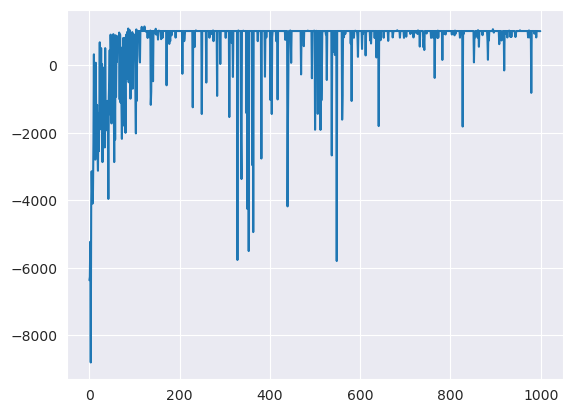

In [614]:
sns.lineplot(x=range(len(total_train_rewards)), y=total_train_rewards)

In [615]:
def test(env):
    env.reset()
    state = get_state(env)
    cargo_paths = dict()
    episode_reward_sum = 0
    step = 0
    while True:

        if step > MAX_STEPS:
            break

        for cargo in env.cargos.keys():
            step += 1
            action = policy_net(state).max(1)[1].view(1, 1)
            is_possible_move = env.check_move(cargo, actions_list[action])

            if not cargo_paths.get(cargo):
                cargo_paths[cargo] = []

            cargo_paths[cargo].append(actions_list[action])
            if is_possible_move:
                env.move_cargo(cargo, actions_list[action])
            else:
                pass

            reward = get_reward(env, is_possible_move)
            if env.is_done():
                reward += 1000

            next_state = get_state(env)
            state = next_state
            episode_reward_sum += reward.item()
            if env.is_done():
                break
        if env.is_done():
            break
    total_train_rewards.append(episode_reward_sum)
    episode_results.append(env.is_done())
    print("Is done: {}".format(env.is_done()))
    print("Cargo positions: ")
    for cargo in env.cargos.keys():
        print(cargo, end=': ')
        for pos in env.cargos[cargo]:
            print(pos, end=' ')
        print()
    print(f'steps performed: {step}')
    print(f'cargo paths: {cargo_paths}')
    print('-' * 40)

In [616]:
test(env)

Is done: True
Cargo positions: 
2: [1 1] [1 2] 
1: [1 3] [2 3] [3 3] 
3: [3 1] 
steps performed: 6
cargo paths: {'2': ['D', 'L'], '1': ['L', 'U'], '3': ['R', 'U']}
----------------------------------------
